# Battle Ship

In [146]:
import numpy as np
import random
random.seed(42)

import seaborn as sns
import matplotlib.pylab as plt

We define some helper functions first

In [147]:
def plot_board(board):
    """Plot a battleship board."""
    plt.title('Battleship board')
    sns.heatmap(board.board, linewidths=0.5, cmap="tab20c", linecolor="black", cbar=False)
    plt.show()

def plot_probability_heatmap(heatmap):
    """Plot a heatmap of the probability of a ship being in each square."""
    plt.title('Probability of ship present on each tile')
    sns.heatmap(heatmap, linewidths=0.5, annot=True, cmap="mako", linecolor="black", cbar=True)
    plt.show()

## 1. Representing the Game

We represent the opponents board as a 2D boolean array, where True means the cell has a ship and False means it doesn't. 

In [148]:
class Board:
    def __init__(self):
        self.board = np.array([[False] * 10] * 10)

    def __str__(self):
        return str(self.board)

    def set_tile(self, row, col, value):
        """Set the value of a tile on the board."""
        self.board[row, col] = value

    def place_ship(self, ship, is_vert, row, col):
        """
        row, col is top left corner of ships
        Returns True if ship was placed successfully and False otherwise
        Assumes row, col in range [0, 9]
        """
        if is_vert:
            # Make sure ship doesn't go off the board
            if row + ship.length > 10:
                return False
            board_slice = self.board[row:row + ship.length, col]
            if np.any(board_slice):
                return False
            self.board[row:row + ship.length, col] = True
        else:
            # Make sure ship doesn't go off the board
            if col + ship.length > 10:
                return False
            board_slice = self.board[row, col:col + ship.length]
            if np.any(board_slice):
                return False
            self.board[row, col:col + ship.length] = True
        return True

    def generate_random_board(self, ships, conditions=None):
        """Generate the board with ships placed randomly."""

        if conditions is None:
            conditions = []

        valid_conditions = False
        while not valid_conditions:
            # Reset board
            self.board[:, :] = False

            # Sequentially place ships
            for ship in ships:
                placed = False
                while not placed:
                    is_vert = random.choice([True, False])
                    row = random.randint(0, 9)
                    col = random.randint(0, 9)
                    placed = self.place_ship(ship, is_vert, row, col)
            
            valid_conditions = self.check_conditions_satisfied(conditions)

    def check_conditions_satisfied(self, conditions):
        """Check if all conditions are satisfied."""
        for row, col, value in conditions:
            if self.board[row, col] != value:
                return False
        return True

            

We then have 5 types of ships: Carried, Battleship, Cruiser, Submarine and Destroyer. These have length 5, 4, 3, 3 and 2 respectively. 

In [149]:
class Ship:
    def __init__(self, name, length):
        self.name = name
        self.length = length
        
ships = [Ship("Carrier", 5), Ship("Battleship", 4), Ship("Cruiser", 3), Ship("Submarine", 3), Ship("Destroyer", 2)]

We can now initialise a new board and place a ship

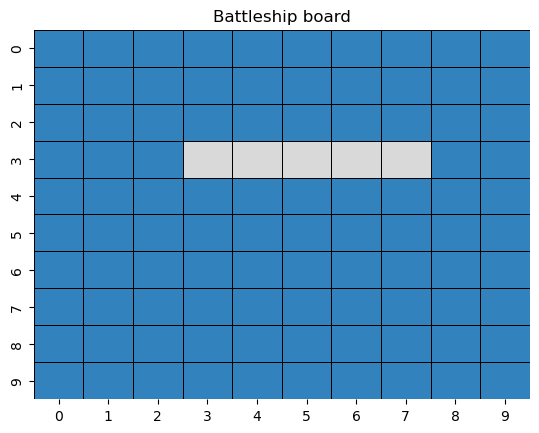

In [150]:
test_board = Board()

# Lets place the Carrier ar row 3, col 3
test_board.place_ship(ships[0], False, 3, 3)
plot_board(test_board)

Lets try randomly placing all our ships now

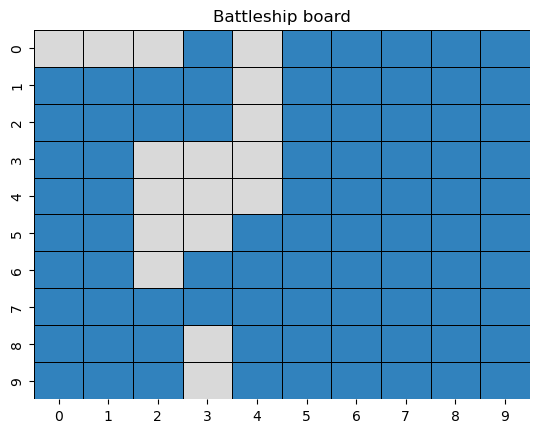

In [151]:
test_board.generate_random_board(ships) # note this function resets the board
plot_board(test_board)

## 2. Computing the Probabilities

Now, we need to find the values of to find the $P(X^i = 1) = \theta^i$: the probability that the $i^{\text{th}}$ tile contains a ship. We know that $X^i \sim Ber(\theta^i)$. Hence, our maximum likelyhood estimator gives us:
$$P(X^i = 1) \approx \frac{1}{n} \sum_{j=1}^{n} x^i_j$$ 

where $x_j^i$ is our $i^{\text{th}}$ observation for the $i^{\text{th}}$ tile from our monete carol. $n$ is the number of trails we do. 

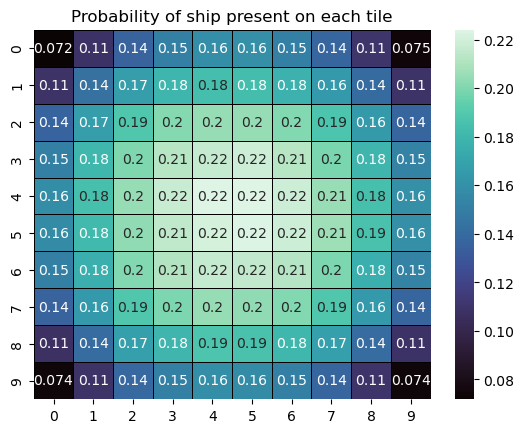

In [152]:
def generate_heatmap(number_of_trials, ships, conditions=None):
    """Generate a heatmap of the probability of a ship being in each square."""
    ship_count_heatmap = np.array([[0] * 10] * 10)
    board = Board()
    for _ in range(n):
        board.generate_random_board(ships, conditions)
        ship_count_heatmap += board.board
    probability_heatmap = ship_count_heatmap / number_of_trials
    return probability_heatmap

n = 10**5
probability_heatmap = generate_heatmap(n, ships)
plot_probability_heatmap(probability_heatmap)


This makes sense. The centre tiles are much more likely to contain ships since there are many ways we can arrage ships in the centre, whereas there fewer ways near the borders. 

Now, what happends to these probabilities when we shoot at a tile? One way to approach this is by conditioning on the result. For example, lets assume we shoot the $0^\text{th}$ tile (row 0, col 0). This is clearly not optimal but with some like we register a hit. Then we need to find $ P(X^i = 1 | X^{0} = 1) $. As before $ X^i = 1 | X^{0} = 1 $ follows a bernouli distribution. Hence, we can using our maximum likelyhood approach again. 

$$P(X^i = 1 | X^{0} = 1) \approx \frac{1}{n} \sum_{j=1}^{n} x^i_j$$

$$\text{Subject to: } x^{0}_j = 1$$

An example board meeting this constraint is shown below. 

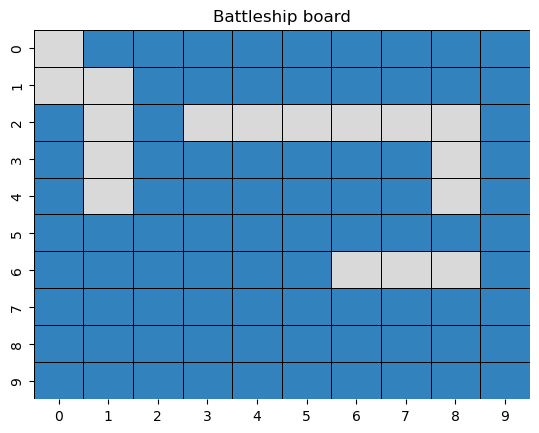

In [153]:
board = Board()

# An example
conditions = [(0, 0, True)]
board.generate_random_board(ships, conditions)
plot_board(board)


We now run run a similair montecarlo to the one above, but now with our constaint that $ x^{0}_j = 1$.

In [154]:
n = 10**4

conditions = [(0, 0, True)]
probability_heatmap = generate_heatmap(n, ships, conditions)
plot_probability_heatmap(probability_heatmap)

We can in fact have an arbitrary amount of these constraints. Lets imaging we shoot tile (4, 4), (5, 5) and (3, 6) and we miss all. Then our the ship probabilities for each ship would look as follows.

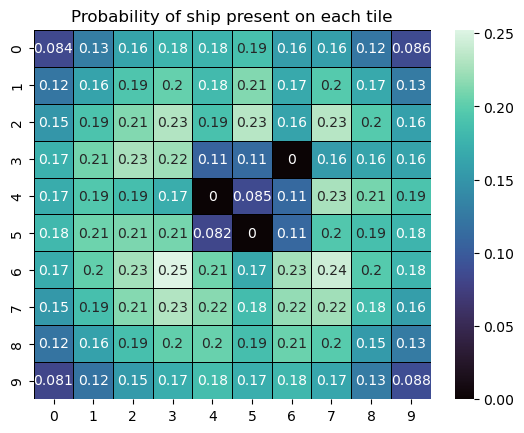

In [ ]:
n = 10**4

conditions = [(4, 4, False), (5, 5, False), (3, 6, False)]
probability_heatmap = generate_heatmap(n, ships, conditions)
plot_probability_heatmap(probability_heatmap)

## Strategy